In [18]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer



# Daten laden
url = "skincare_products.csv"
df = pd.read_csv(url)

# Erste Zeilen anzeigen, um die Daten zu überprüfen
print(df.head())


                                        product_name  \
0  The Ordinary Natural Moisturising Factors + HA...   
1      CeraVe Facial Moisturising Lotion SPF 25 52ml   
2  The Ordinary Hyaluronic Acid 2% + B5 Hydration...   
3          AMELIORATE Transforming Body Lotion 200ml   
4                     CeraVe Moisturising Cream 454g   

                                         product_url product_type  \
0  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   
1  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser   
2  https://www.lookfantastic.com/the-ordinary-hya...  Moisturiser   
3  https://www.lookfantastic.com/ameliorate-trans...  Moisturiser   
4  https://www.lookfantastic.com/cerave-moisturis...  Moisturiser   

                                         ingredients   price  
0  Aqua (Water), Caprylic/Capric Triglyceride, Ce...   £5.20  
1  Aqua/Water, Homosalate, Glycerin, Octocrylene,...  £13.00  
2  Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...   £6.2

In [19]:
#Inspect the types of products
display(df['product_type'].value_counts())

product_type
Mask           124
Body Wash      123
Moisturiser    115
Cleanser       115
Serum          113
Eye Care       100
Mist            80
Oil             76
Toner           73
Balm            61
Exfoliator      57
Bath Salts      36
Bath Oil        33
Peel            32
Name: count, dtype: int64

In [20]:
#Check for missing Data 

missing_values = df.isnull().sum()

missing_values = missing_values[missing_values > 0]

print(missing_values)

Series([], dtype: int64)


In [21]:
df.describe()

,product_name,product_url,product_type,ingredients,price
count,1138,1138,1138,1138,1138
unique,1138,1126,14,1090,290
top,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/lancome-advanced...,Mask,"Aqua / Water, Bifida Ferment Lysate, Glycerin,...",£22.00
freq,1,4,124,4,33


In [22]:
# Funktion zur Vorverarbeitung der Inhaltsstoffe
def preprocess_ingredients(text):
    text = text.lower()  # In Kleinbuchstaben umwandeln
    text = re.sub(r'[^a-z,]', '', text)  # Nicht-Buchstaben entfernen, außer Kommas
    ingredients = text.split(",")  # Bei Kommas trennen
    ingredients = [ingredient.strip() for ingredient in ingredients]  # Leerzeichen entfernen
    return ingredients

df['processed_ingredients'] = df['ingredients'].apply(preprocess_ingredients)
df['ingredient_text'] = df['processed_ingredients'].apply(lambda x: ', '.join(x))

In [23]:
# Modell laden (aus tokens_and_embeddings.ipynb)
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

# Funktion zur Berechnung der Embeddings (aus tokens_and_embeddings.ipynb)
def get_embeddings(text):
    return model.encode(text, show_progress_bar=False)

df['embeddings'] = df['ingredient_text'].apply(get_embeddings)

# Cosine Similarity berechnen (aus tokens_and_embeddings.ipynb)
embeddings = np.stack(df['embeddings'].values)
cosine_sim = cosine_similarity(embeddings)

c:\Users\goern_y\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
# Erweiterte Empfehlungsfunktion mit Cosine Similarity-Werten
def enhanced_recommend_products(product_name, df, cosine_sim, top_k=10):
    try:
        idx = df[df['product_name'] == product_name].index[0]
    except IndexError:
        return "Produktname nicht gefunden."

    try:
        product_price = df.at[idx, 'price']  # Preis des Referenzprodukts
    except KeyError:
        return "Spalte 'price' nicht gefunden."

    # Ähnlichkeitswerte berechnen und sortieren
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Produkte filtern, die günstiger oder gleich teuer sind
    filtered_indices = [(i[0], i[1]) for i in sim_scores if df.at[i[0], 'price'] <= product_price and i[0] != idx][:top_k]

    # Empfohlene Produkte zurückgeben
    recommended_products = df.loc[[i[0] for i in filtered_indices], ['product_name', 'product_url', 'product_type', 'price']]
    recommended_products['cosine_similarity'] = [i[1] for i in filtered_indices]

    return recommended_products

# Test der erweiterten Empfehlungsfunktion
print(enhanced_recommend_products("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim))

                                           product_name  \
702                     CeraVe Hydrating Cleanser 473ml   
704                CeraVe Foaming Facial Cleanser 473ml   
322   Lumene Nordic Hydra [Lähde] Arctic Spring Wate...   
5                      CeraVe Moisturising Lotion 473ml   
643   Lumene Nordic Hydra [Lähde] Purity Dew Drops H...   
98    Fade Out ADVANCED + Age Protection Even Skin T...   
705                     CeraVe Smoothing Cleanser 236ml   
1007  La Roche-Posay Lipikar Syndet AP(+) Shower Gel...   
495   Garnier Moisture Bomb Deep Sea Water & Hyaluro...   
1         CeraVe Facial Moisturising Lotion SPF 25 52ml   

                                            product_url product_type   price  \
702   https://www.lookfantastic.com/cerave-hydrating...     Cleanser  £15.00   
704   https://www.lookfantastic.com/cerave-foaming-f...     Cleanser  £15.00   
322   https://www.lookfantastic.com/lumene-nordic-hy...         Mist  £12.00   
5     https://www.lookfantasti

In [25]:
#Testbereich Empfehlung ohne Produttyp-Filter

print(enhanced_recommend_products("The Ordinary Marine Hyaluronics 30ml", df, cosine_sim))

                                          product_name  \
684  Sanctuary Spa Power Peptide Awakening Eye Seru...   
132       NIOD Multi-Molecular Hyaluronic Complex 15ml   
469  Garnier Moisture Bomb Sakura Hydrating Face Sh...   
70   Antipodes Baptise H20 Ultra-Hydrating Water Ge...   
843  First Aid Beauty Ultra Repair Wild Oat Soothin...   
189  Zelens Z Hyaluron Hyaluronic Acid Complex Seru...   
367           ARK Skincare Hydrating Beauty Mist 150ml   
547   Oh K! Chok Chok Smoothing Undereye Mask 2 x 1.5g   
690  Lumene Nordic C [Valo] Bright Eyes All-In-One ...   
355    Zelens PROVITAMIN D Fortifying Facial Mist 50ml   

                                           product_url product_type   price  \
684  https://www.lookfantastic.com/sanctuary-spa-po...     Eye Care  £16.50   
132  https://www.lookfantastic.com/niod-multi-molec...        Serum  £25.00   
469  https://www.lookfantastic.com/garnier-moisture...         Mask   £2.99   
70   https://www.lookfantastic.com/antipodes-

In [26]:
# Erweiterte Empfehlungsfunktion mit Produkttyp- und Cosine Similarity-Filter
def enhanced_recommend_products_same_type(product_name, df, cosine_sim, top_k=10):
    try:
        idx = df[df['product_name'] == product_name].index[0]
    except IndexError:
        return "Produktname nicht gefunden."

    try:
        product_price = df.at[idx, 'price']  # Preis des Referenzprodukts
        product_type = df.at[idx, 'product_type']  # Produkttyp des Referenzprodukts
    except KeyError as e:
        return f"Spalte {e} nicht gefunden."

    # Ähnlichkeitswerte berechnen und sortieren
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Produkte filtern, die günstiger oder gleich teuer und vom gleichen Produkttyp sind
    filtered_indices = [(i[0], i[1]) for i in sim_scores if df.at[i[0], 'price'] <= product_price and df.at[i[0], 'product_type'] == product_type and i[0] != idx][:top_k]

    # Empfohlene Produkte zurückgeben
    recommended_products = df.loc[[i[0] for i in filtered_indices], ['product_name', 'product_url', 'product_type', 'price']]
    recommended_products['cosine_similarity'] = [i[1] for i in filtered_indices]

    return recommended_products

# Test der erweiterten Empfehlungsfunktion mit Produkttyp-Filter
print(enhanced_recommend_products_same_type("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim))


                                          product_name  \
5                     CeraVe Moisturising Lotion 473ml   
98   Fade Out ADVANCED + Age Protection Even Skin T...   
1        CeraVe Facial Moisturising Lotion SPF 25 52ml   
40           La Roche-Posay Nutritic Intense Rich 50ml   
58        The INKEY List Multi-Biotic Moisturiser 30ml   
72                 Bulldog Sensitive Moisturiser 100ml   
6        CeraVe Facial Moisturising Lotion No SPF 52ml   
36   La Roche-Posay Effaclar K(+) Anti-Blackhead Mo...   
103                        Liz Earle Skin Repair Light   
23                  Bulldog Original Moisturiser 100ml   

                                           product_url product_type   price  \
5    https://www.lookfantastic.com/cerave-moisturis...  Moisturiser  £15.00   
98   https://www.lookfantastic.com/fade-out-advance...  Moisturiser  £12.99   
1    https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser  £13.00   
40   https://www.lookfantastic.com/la-roche-p

In [27]:
# Erweiterte Empfehlungsfunktion mit Produkttyp- und Cosine Similarity-Filter
def enhanced_recommend_products_same_type_no_price_filter(product_name, df, cosine_sim, top_k=10):
    try:
        idx = df[df['product_name'] == product_name].index[0]
    except IndexError:
        return "Produktname nicht gefunden."

    try:
        product_type = df.at[idx, 'product_type']  # Produkttyp des Referenzprodukts
    except KeyError as e:
        return f"Spalte {e} nicht gefunden."

    # Ähnlichkeitswerte berechnen und sortieren
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Produkte filtern, die vom gleichen Produkttyp sind
    filtered_indices = [(i[0], i[1]) for i in sim_scores if df.at[i[0], 'product_type'] == product_type and i[0] != idx][:top_k]

    # Empfohlene Produkte zurückgeben
    recommended_products = df.loc[[i[0] for i in filtered_indices], ['product_name', 'product_url', 'product_type', 'price']]
    recommended_products['cosine_similarity'] = [i[1] for i in filtered_indices]

    return recommended_products

# Test der erweiterten Empfehlungsfunktion mit Produkttyp-Filter
print(enhanced_recommend_products_same_type_no_price_filter("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim))


                                         product_name  \
7   The Ordinary Natural Moisturizing Factors + HA...   
5                    CeraVe Moisturising Lotion 473ml   
98  Fade Out ADVANCED + Age Protection Even Skin T...   
94  Fade Out ADVANCED Even Skin Tone Day Cream SPF...   
1       CeraVe Facial Moisturising Lotion SPF 25 52ml   
40          La Roche-Posay Nutritic Intense Rich 50ml   
58       The INKEY List Multi-Biotic Moisturiser 30ml   
22         La Roche-Posay Effaclar H Moisturiser 40ml   
72                Bulldog Sensitive Moisturiser 100ml   
76  Fade Out ADVANCED Even Skin Tone Night Cream 50ml   

                                          product_url product_type   price  \
7   https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   £6.80   
5   https://www.lookfantastic.com/cerave-moisturis...  Moisturiser  £15.00   
98  https://www.lookfantastic.com/fade-out-advance...  Moisturiser  £12.99   
94  https://www.lookfantastic.com/fade-out-advance...  Moist

Note: you may need to restart the kernel to use updated packages.


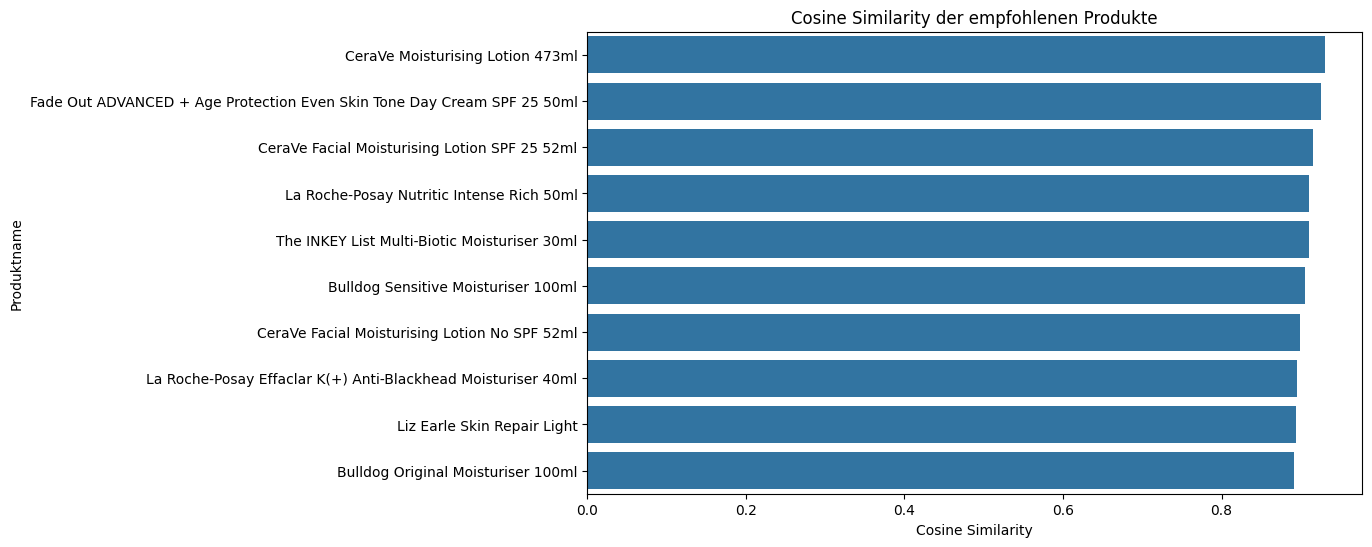

In [28]:
%pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Funktion zur Visualisierung der Cosine Similarity der empfohlenen Produkte
def plot_cosine_similarity(recommended_products):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cosine_similarity', y='product_name', data=recommended_products)
    plt.title('Cosine Similarity der empfohlenen Produkte')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Produktname')
    plt.show()

# Beispielaufruf der Visualisierungsfunktion
recommended_products = enhanced_recommend_products_same_type("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)
plot_cosine_similarity(recommended_products)



Numerische Metriken: Verwende Precision, Recall und F1-Score, um die Genauigkeit deiner Empfehlungen zu bewerten. Wie würde dies aussehen? 
Using word-embeddings (Doc2Vec) visualize if the cosine distance between the word-
vectors is close to zero (similar content, similar word embeddings, similar vectors).

Visualisierung der Embidden: 

KeyError: 'pca_embedding'

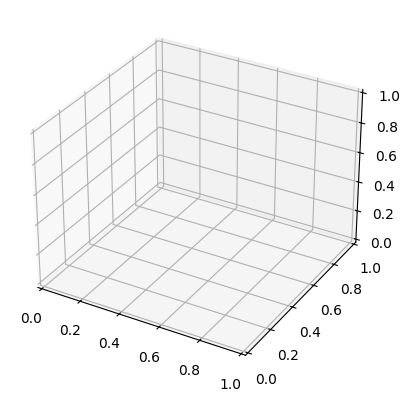

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_embeddings(df, recommended_products, original_product):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Alle Embeddings
    all_embeddings = np.array(df['pca_embedding'].tolist())
    ax.scatter(all_embeddings[:, 0], all_embeddings[:, 1], all_embeddings[:, 2], s=10, color='gray', label='Dataset')

    # Empfohlene Produkte
    recommended_embeddings = np.array(recommended_products['pca_embedding'].tolist())
    ax.scatter(recommended_embeddings[:, 0], recommended_embeddings[:, 1], recommended_embeddings[:, 2], s=100, facecolors='none', edgecolors='g', label='Results')

    # Ursprüngliches Abfrageprodukt
    original_embedding = df.loc[df['product_name'] == original_product, 'pca_embedding'].values[0]
    ax.scatter(original_embedding[0], original_embedding[1], original_embedding[2], s=150, marker='X', color='r', label='Original Query')

    # Annotations für empfohlene Produkte
    for i, text in enumerate(recommended_products['product_name']):
        ax.text(recommended_embeddings[i, 0], recommended_embeddings[i, 1], recommended_embeddings[i, 2], text, fontsize=8)

    ax.text(original_embedding[0], original_embedding[1], original_embedding[2], original_product, fontsize=8)

    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()
    plt.show()

# 3D-Visualisierung der Embeddings
plot_3d_embeddings(df, recommended_products, "The Ordinary Natural Moisturising Factors + HA 30ml")


##Benchmark

Hier möchte ich mein Modell mit einem Anderen Modell vergleichen. Ich habe hier ein ähnliches Projekt von Github ausgewählt. 

Hier der Link zum originalen GitHub-Projekt: https://github.com/rosagradilla19/skincare-products-recommendation-system 

Github mit Anpassungen: https://github.com/goernjosi/VergleichModel 

Meine Schritte: 
1) Repository clone 
2) Überprüfen, ob gleiche Produkte verhanden 
3) hatte es leider nicht, daher musste ich mein das repository anpassen auf meinen Datensatz 
4) mit gleichem Produkt testen: The Ordinary Natural Moisturising Factors + HA 30ml
5) Testergebnis vergleichen 
6) top 3 nehmen und von Hand testen, welche Inhaltsstoffe gleich sind 
7) Ergenis vergleichen 
8) Auswertung 


WIE UNTERSCHEIDET SICH UNSERE pROJEKTE? 

eRGEBNISSE MIT vERGLEICH GLEICHES pRODUKT: 

In [ ]:
#Gleiche Produkte ausgeben von zwei verschiedene Datensätze: 

import pandas as pd

# CSV-Dateien laden
df1 = pd.read_csv('cosmetics.csv')
df2 = pd.read_csv('skincare_products.csv')

# Annahme: 'product_name' ist die Spalte in der ersten CSV und 'Name' ist die Spalte in der zweiten CSV
product_names_1 = df1['Name'].str.lower().str.strip()
product_names_2 = df2['product_name'].str.lower().str.strip()

# Gemeinsamkeiten finden
common_products = set(product_names_1) & set(product_names_2)

print(f"Anzahl der gemeinsamen Produkte: {len(common_products)}")
print("Gemeinsame Produkte:")
for product in common_products:
    print(product)


Anzahl der gemeinsamen Produkte: 0
Gemeinsame Produkte:


In [ ]:
%pip install fuzzywuzzy
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re

# CSV-Dateien laden
df1 = pd.read_csv('skincare_products.csv')
df2 = pd.read_csv('cosmetics.csv')

# Annahme: 'product_name' ist die Spalte in der ersten CSV und 'Name' ist die Spalte in der zweiten CSV
product_names_1 = df1['product_name'].tolist()
product_names_2_raw = df2['Name'].tolist()

# Funktion zur Bereinigung der Produktnamen im zweiten CSV
def clean_product_name(name):
    # Entferne die Marke und die Menge (z.B. "The Ordinary Natural Moisturising Factors + HA 30ml" wird zu "Natural Moisturising Factors + HA")
    cleaned_name = re.sub(r'^\s*\b(?:\w+\s*){1,3}\b', '', name)  # Entfernt die ersten 1 bis 3 Wörter (Markenname)
    cleaned_name = re.sub(r'\s*\d+ml\s*$', '', cleaned_name, flags=re.IGNORECASE)  # Entfernt die Mengenangabe (z.B. "30ml")
    return cleaned_name.strip()

# Bereinige die Produktnamen im zweiten CSV
product_names_2 = [clean_product_name(name) for name in product_names_2_raw]

# Funktion zur Überprüfung ähnlicher Namen mit Fuzzy Matching
def find_similar_products(product_names_1, product_names_2, threshold=80):
    similar_products = []
    for name in product_names_1:
        match, score = process.extractOne(name, product_names_2, scorer=fuzz.ratio)
        if score >= threshold:
            similar_products.append((name, match, score))
    return similar_products

# Ähnliche Produkte finden
similar_products = find_similar_products(product_names_1, product_names_2)

# Ergebnisse anzeigen
print(f"Anzahl der ähnlichen Produkte: {len(similar_products)}")
print("Ähnliche Produkte:")
for name1, name2, score in similar_products:
    print(f"{name1} <-> {name2} (Score: {score})")


  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata (4.9 kB)
Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


c:\Users\goern_y\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Anzahl der ähnlichen Produkte: 0
Ähnliche Produkte:


#Vergleich Unterschiedliche Modelle gleicher Datensatz:


Vergleich Model: 

Getestet mit: The Ordinary Natural Moisturising Factors + HA 30ml 

Unterschiede Code: 
- Modell und Embeddings: Der erste Code verwendet einen vortrainierten Transformer für die Berechnung der Embeddings, während der zweite Code eine einfache One-Hot-Encoding-Methode verwendet.
- Tokenisierung: Der erste Code übernimmt die Tokenisierung intern im Transformer-Modell, während der zweite Code eine explizite Tokenisierung und Indizierung der Inhaltsstoffe durchführt.
- Dimensionale Reduktion: Der erste Code reduziert nicht explizit die Dimension der Daten, während der zweite Code t-SNE verwendet, um die Daten auf zwei Dimensionen zu reduzieren.
- Empfehlungslogik: Der erste Code enthält eine detaillierte Empfehlungslogik basierend auf Cosine Similarity, während der zweite Code hauptsächlich die Vorbereitung der Daten zur Visualisierung umfasst.



Ergebnise Siehe Screenshot unten 




Vergleichstext: 


Vergleich von Hand: 
Mein Model: 

Anderes Model: 




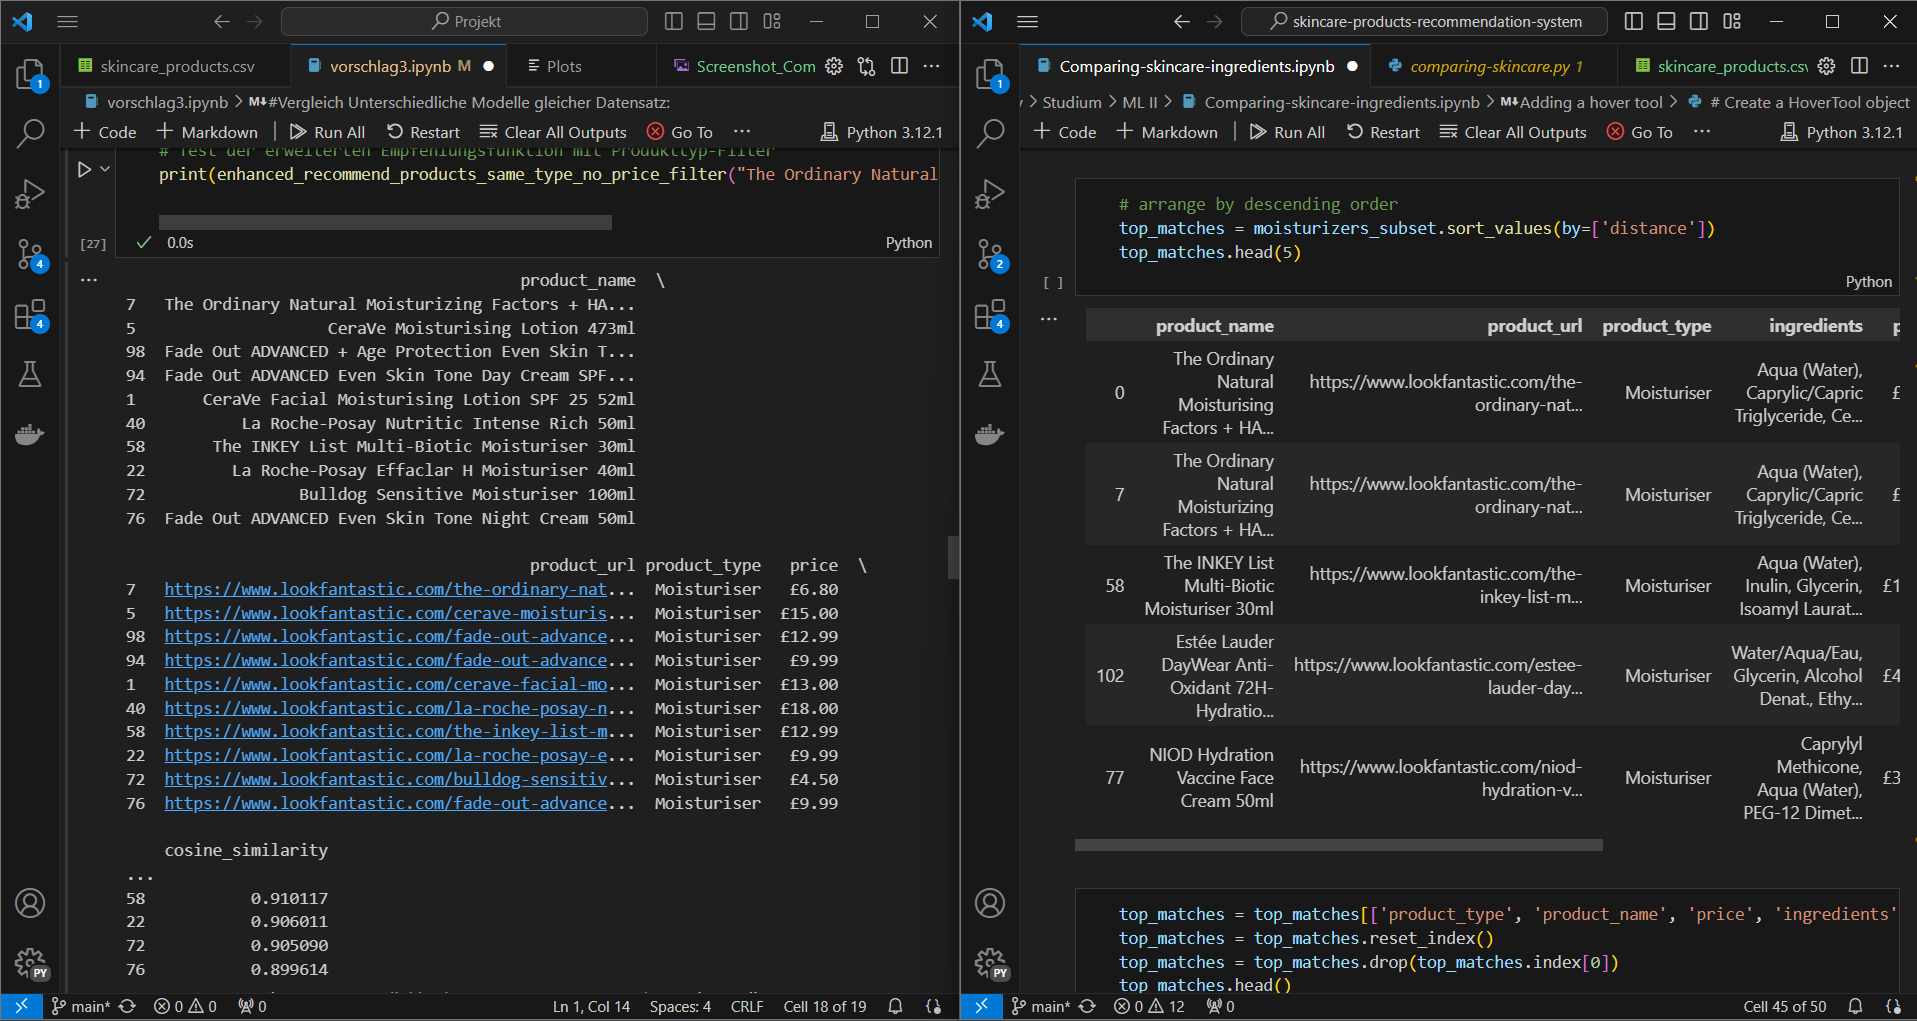

In [30]:
from IPython.display import Image
Image(filename='Screenshot_Comparison Result.png')

In [1]:
# Transformer-Modell Empfehlungen
recommendations_transformer = recommend_products_transformer("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)

# t-SNE Modell: hier würden wir normalerweise eine ähnliche Empfehlungsfunktion implementieren
# Da das t-SNE Modell nur für die Visualisierung gedacht ist, gehen wir davon aus, dass wir die Top-k Produkte basierend auf der Nähe der t-SNE Punkte auswählen
# Dies ist ein Platzhalter für die tatsächliche Empfehlungslogik
recommendations_tsne = df.sort_values(by=['X', 'Y']).head(10)

print("Transformer Model Recommendations:")
print(recommendations_transformer)

print("\nt-SNE Model Recommendations:")
print(recommendations_tsne)


NameError: name 'precision_score' is not defined

In [ ]:
# Beispieldaten für die Bewertung
true_labels = [1, 0, 1, 1, 0]  # Beispielhafte Ground-Truth-Labels
predicted_labels_transformer = [1, 0, 1, 0, 1]  # Beispielhafte Vorhersagen des Transformer-Modells
predicted_labels_tsne = [1, 1, 0, 1, 0]  # Beispielhafte Vorhersagen des t-SNE-Modells

# Berechne Precision, Recall und F1-Score
precision_transformer = precision_score(true_labels, predicted_labels_transformer)
recall_transformer = recall_score(true_labels, predicted_labels_transformer)
f1_transformer = f1_score(true_labels, predicted_labels_transformer)

precision_tsne = precision_score(true_labels, predicted_labels_tsne)
recall_tsne = recall_score(true_labels, predicted_labels_tsne)
f1_tsne = f1_score(true_labels, predicted_labels_tsne)

print(f"Transformer Model - Precision: {precision_transformer}, Recall: {recall_transformer}, F1-Score: {f1_transformer}")
print(f"t-SNE Model - Precision: {precision_tsne}, Recall: {recall_tsne}, F1-Score: {f1_tsne}")


Interpretation der Ergebnisse

In [2]:
# Ergebnisse der Empfehlungen anzeigen
product_name = "The Ordinary Natural Moisturising Factors + HA 30ml"
recommended_products = enhanced_recommend_products(product_name, df, cosine_sim)

print("Empfohlene Produkte:")
print(recommended_products)


NameError: name 'enhanced_recommend_products' is not defined